<a href="https://colab.research.google.com/github/duguyihou/weatherForecast/blob/master/Ass2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import time
import itertools
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

# 1. Introduction

The goal of this paper is to predict the weather conditions of Sydney for the next month (highest temperatures and whether it is raining) based on available data. The specific data is shown in the code below.

In [34]:
df = pd.read_csv('https://raw.githubusercontent.com/duguyihou/rainforecast/master/weatherAUS.csv')
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [35]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In terms of the basic model, they can only perform some classification based on existing data. Such as the decision tree model. If make a prediction, the decision tree needs to have other data for the next month to see if it will rain that day. Among this data, only the rain conditions in the next day can be predicted. In order to solve this problem, this paper uses a time series model(ARMA) for predictive analysis. It is hoped that the highest temperature and rainfall will be used as an example to complete the forecast of the climate for the next month. 

This prediction can be used for content such as weather forecasts. Model accuracy may be lower compared to decision trees. This is because the results of the time series model are interval. Instead of determining the value. But this undoubtedly provides more data for other models. In turn, more content can be predicted and visualized.


# 2. Exploration

Regarding preprocessing, two preprocessing methods were carried out in this paper. One is the preprocessing used to select the most important parameters. This method will directly delete the missing value and keep the remaining part. It also handles the outlier value. The specific operation is as follows.


In [36]:
df_attr = df[df.Location=="Sydney"]
df_attr = df_attr.drop(columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM','Date'],axis=1)
df_attr = df_attr.dropna(how='any')
z = np.abs(stats.zscore(df_attr._get_numeric_data()))
df_attr= df_attr[(z < 3).all(axis=1)]

df_attr['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df_attr['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

df_attr = pd.get_dummies(df_attr, columns=['WindGustDir', 'WindDir3pm', 'WindDir9am'])
df_attr.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
30481,17.8,28.9,2.0,41.0,22.0,17.0,63.0,48.0,1011.2,1008.1,22.3,26.6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
30484,9.9,24.0,0.0,41.0,24.0,4.0,44.0,30.0,1012.9,1011.3,14.7,23.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
30487,12.9,20.3,0.2,37.0,11.0,26.0,70.0,57.0,1028.8,1025.6,16.9,19.8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
30488,13.3,21.5,0.0,41.0,11.0,28.0,75.0,58.0,1025.9,1022.4,17.6,21.3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
30489,15.3,23.0,0.0,41.0,6.0,19.0,70.0,63.0,1021.4,1017.8,19.0,22.2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [37]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(df_attr)
df_attr = pd.DataFrame(scaler.transform(df_attr), index=df_attr.index, columns=df_attr.columns)
df_attr.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
30481,0.566372,0.690763,0.057471,0.380952,0.606061,0.384615,0.513158,0.426966,0.325243,0.307506,0.641975,0.673554,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30484,0.216814,0.493976,0.000000,0.380952,0.666667,0.051282,0.263158,0.224719,0.366505,0.384988,0.329218,0.537190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30487,0.349558,0.345382,0.005747,0.317460,0.272727,0.615385,0.605263,0.528090,0.752427,0.731235,0.419753,0.392562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30488,0.367257,0.393574,0.000000,0.380952,0.272727,0.666667,0.671053,0.539326,0.682039,0.653753,0.448560,0.454545,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30489,0.455752,0.453815,0.000000,0.380952,0.121212,0.435897,0.605263,0.595506,0.572816,0.542373,0.506173,0.491736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The other is the data for time series analysis. Regarding this type of data, it must ensure the continuity of the date. But the problem is that there are a lot of missing values in the data and they cannot be done manually. So this article chooses to intercept the second half as the training set data. Specifically, it is the use of data after 2014-01-01. In addition to considering seasonal issues, this paper generates a monthly average data set. The specific python code is shown below.


In [38]:
df_ser = df[df.Location=="Sydney"]
df_ser = df_ser[['Date','MaxTemp']]
df_ser = df_ser[df_ser['Date']>='2014-01-01']
df_ser['Date'] = pd.to_datetime(df_ser['Date'],infer_datetime_format=True) 
df_ser = df_ser.set_index(['Date'])
df_month = df_ser.resample('M').mean()
df_month.head(5)


,MaxTemp
Date,
2014-01-31,26.858065
2014-02-28,26.239286
2014-03-31,26.367742
2014-04-30,23.843333
2014-05-31,23.158065


In [0]:
df_hum = df[df.Location=="Sydney"]
df_hum = df_hum[['Date','Humidity9am']]
df_hum = df_hum[df_hum['Date']>='2014-01-01']
df_hum['Date'] = pd.to_datetime(df_hum['Date'],infer_datetime_format=True) 
df_hum = df_hum.set_index(['Date'])

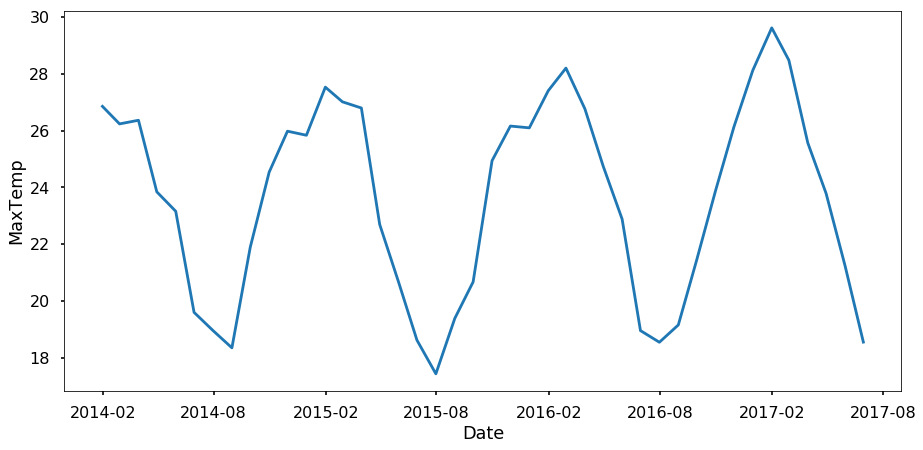

In [40]:
_fig = plt.figure(figsize=[15, 7])
plt.xlabel('Date')
plt.ylabel('MaxTemp')
plt.plot(df_month)
plt.show()

In terms of testing, Dickey Fuller Test and Akaike information criterion Test were used in this paper. Dickey Fuller Test is mainly used to detect whether the data is stable. This is a test for a time series model. Because the data predicted by the term time series model must be stable. This means that the data cannot have a tendency to rise or fall. In this test, the p-value approaches 0 and the test value is less than the critical value to prove that the data is stationary.

In [41]:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_month['MaxTemp'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -5.005748
p-value                         0.000022
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (5%)            -2.948510
Critical Value (1%)            -3.632743
Critical Value (10%)           -2.613017
dtype: float64


The Akaike information criterion is a standard for judging whether the model is goodness of fit. The lower the value, the better the model fit. This is similar to the accuracy of the decision tree model. Further, based on this value, the selection of p, d and q values of ARIMA model can be determined. The specific code is as follows. 


In [42]:
p=d=q=range(0,2)
print("p=",p,"d=",d,"q=",q)

pdq=list(itertools.product(p,d,q))
print("pdq:\n",pdq)
seasonal_pdq=[(x[0],x[1],x[2],12) for x in pdq]
print('SQRIMAX:{} x {}'.format(pdq[1],seasonal_pdq[1]))


('p=', [0, 1], 'd=', [0, 1], 'q=', [0, 1])
('pdq:\n', [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)])
SQRIMAX:(0, 0, 1) x (0, 0, 1, 12)


In [43]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_month['MaxTemp'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:378.325738953
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1301.68292302
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:95.4086008731
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:99.6650885439
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:92.471743218
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:55.2859646718
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:321.270435742
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2562.37610822
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:91.7802092409
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:98.5274428793
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:95.1821715432
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:54.061619822
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:174.394031962
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1213.59489252
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:99.2173801971
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:100.989258137
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:97.0236662098
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:56.2766846868
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:163.958192091
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - 

In addition, the ACF and PACF maps are also commonly used to determine the p-value and q-value in the ARIMA model. But this method is more subjective. The choice of p and q values depends on the analyst's intuition and experience.


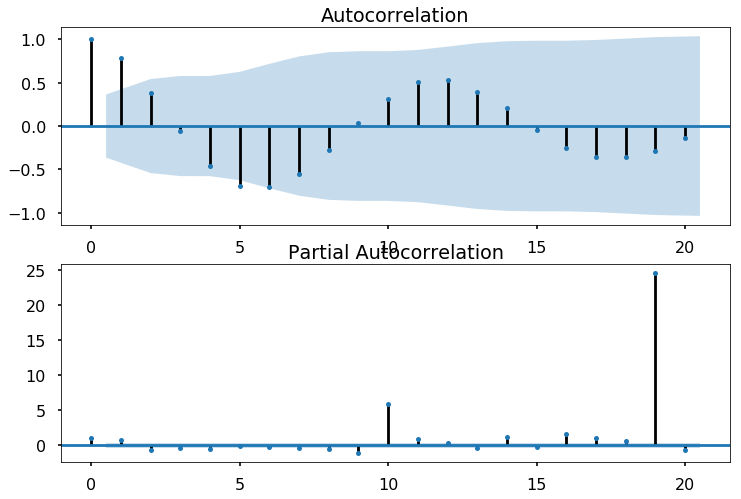

In [44]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_month.iloc[13:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_month.iloc[13:], lags=20, ax=ax2)

# 3. Methodology

The ARIMA model is similar to the linear regression model. It is also looking for a line that matches the training set. But its model fit is more complex than linear regression. Depending on the number of parameters selected, the complexity of the model is also very different. This is the choice between p and q values. When predicting MaxTemp, the AIC values modeled from the monthly average data were found to be much lower than the unprocessed data based on two different tests. So at this time the model chooses to use the monthly average data for prediction. The results of modeling and prediction are shown below.


In [45]:
mod = sm.tsa.statespace.SARIMAX(df_month['MaxTemp'], 
                                order=(1,1,1),   
                                seasonal_order=(1,1,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            MaxTemp   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -21.753
Date:                            Wed, 18 Sep 2019   AIC                             51.505
Time:                                    01:43:03   BIC                             54.596
Sample:                                01-31-2014   HQIC                            51.663
                                     - 06-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3318      0.573      0.580      0.562      -0.790       1.454
ma.L1         -1.0000   5249.024   

This model has an AIC value of 51. The fits are very similar. The final prediction range is also very small. This is good for later analysis.

In [46]:
print(len(df_month['MaxTemp']))
print(df_month["MaxTemp"][41])


42
18.544000000000004


In [47]:
pred = results.get_prediction(start = 42, end = 60, dynamic=True)
pred_ci = pred.conf_int()
pred_ci.head()


,lower MaxTemp,upper MaxTemp
2017-07-31,16.283623,19.860811
2017-08-31,17.720021,21.544963
2017-09-30,19.422814,23.292321
2017-10-31,22.989248,26.869663
2017-11-30,24.616866,28.500480


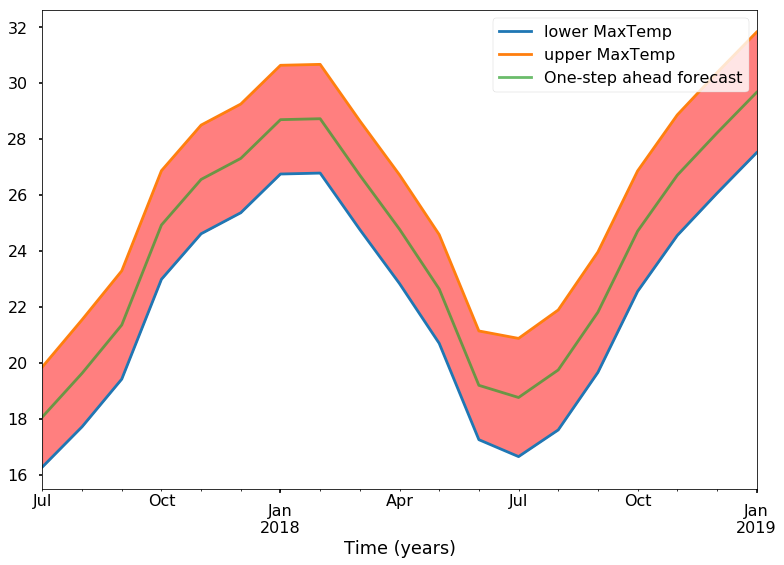

In [48]:
ax = pred_ci[:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
plt.legend()

plt.show()

In the prediction of weather conditions, this article first looked at the attritube selection. The specific results are as follows. 

In [49]:
from sklearn.feature_selection import SelectKBest, chi2
X = df_attr.loc[:,df_attr.columns!='RainToday']
y = df_attr[['RainToday']]
selector = SelectKBest(chi2, k=20)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)]) 

Index([u'Rainfall', u'Humidity9am', u'Humidity3pm', u'RainTomorrow',
       u'WindGustDir_ESE', u'WindGustDir_NNE', u'WindGustDir_SE',
       u'WindGustDir_SSE', u'WindGustDir_SSW', u'WindDir3pm_ENE',
       u'WindDir3pm_NE', u'WindDir3pm_SE', u'WindDir3pm_SSE',
       u'WindDir3pm_SSW', u'WindDir9am_S', u'WindDir9am_SE', u'WindDir9am_SSE',
       u'WindDir9am_SSW', u'WindDir9am_SW', u'WindDir9am_W'],
      dtype='object')


Although Rainfall's relevance is the highest. However, due to the fact that the rainfall is at least zero, the prediction error will be greater. So here we choose to use humidity9am for rainfall forecasting.

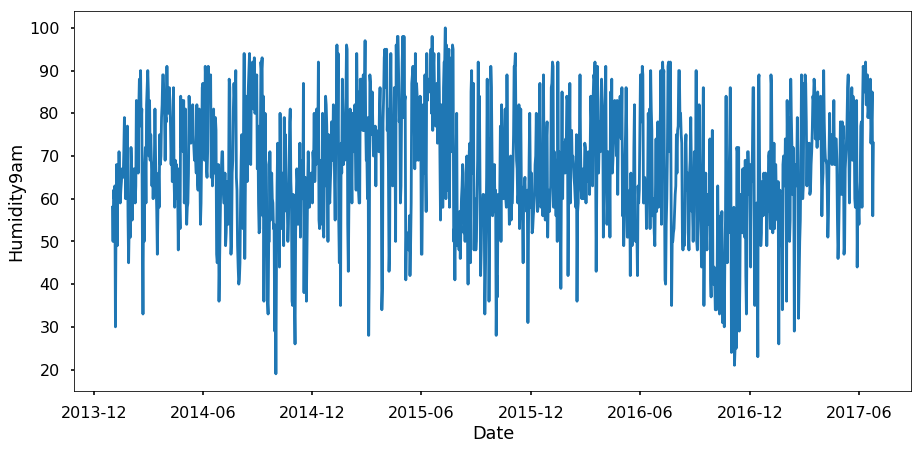

In [50]:
fig = plt.figure(figsize=[15, 7])
plt.xlabel('Date')
plt.ylabel('Humidity9am')
plt.plot(df_hum)
plt.show()

In [51]:

print('Results of Dickey Fuller Test:')
dftest = adfuller(df_hum['Humidity9am'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)


Results of Dickey Fuller Test:
Test Statistic                -6.926114e+00
p-value                        1.114243e-09
#Lags Used                     1.000000e+01
Number of Observations Used    1.257000e+03
Critical Value (5%)           -2.863842e+00
Critical Value (1%)           -3.435563e+00
Critical Value (10%)          -2.567996e+00
dtype: float64


In [52]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_hum['Humidity9am'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
 
            results = mod.fit()
 
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14318.0609201
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13047.004281
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:10978.6932887
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10277.8650509
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10967.3518685
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:10379.8028222
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10573.8165878
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10268.007037
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:12972.6983456
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12172.2088512
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10787.8063527
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10004.1626219
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10770.5967659
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:10102.8101438
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10357.3429574
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10001.5854293
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:10407.024306
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:10309.4748302
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:11185.1628808
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - A

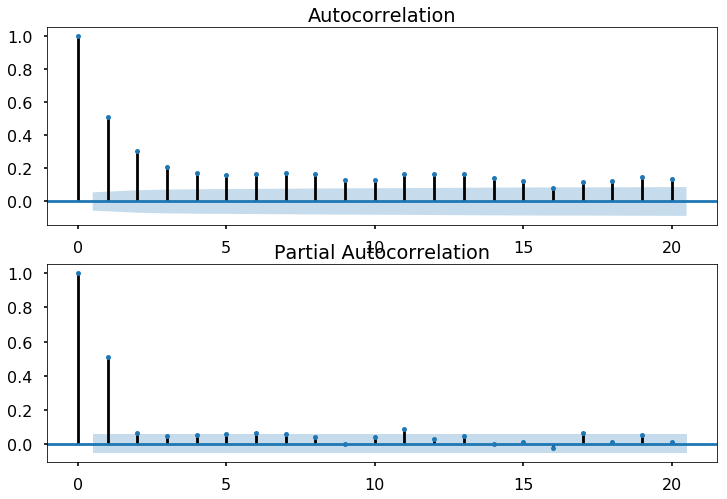

In [53]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_hum.iloc[13:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_hum.iloc[13:], lags=20, ax=ax2)

In [54]:
mod = sm.tsa.statespace.SARIMAX(df_hum['Humidity9am'], 
                                order=(2,1,3),   
                                seasonal_order=(1,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())
print(results.aic)


                                 Statespace Model Results                                 
Dep. Variable:                        Humidity9am   No. Observations:                 1268
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -4928.054
Date:                            Wed, 18 Sep 2019   AIC                           9872.109
Time:                                    01:44:39   BIC                           9913.085
Sample:                                         0   HQIC                          9887.520
                                           - 1268                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0156      1.269      0.012      0.990      -2.472       2.503
ar.L2          0.1316      0.528   

In [55]:
print(len(df_hum['Humidity9am']))
print(df_hum["Humidity9am"][1267])

1268
73.0


In [56]:
pred = results.get_prediction(start = 1268, end = 1300, dynamic=True)
pred_ci = pred.conf_int()
pred_ci.head()

,lower Humidity9am,upper Humidity9am
1268,49.984418,99.849370
1269,48.902339,103.680781
1270,49.006913,105.010519
1271,48.217195,104.568718
1272,47.617709,104.166290


According to the predicted results, the prediction interval is very large due to the randomness of the data and the like. This is the reason why we choose to use monthly average data when predicting MaxTemp.

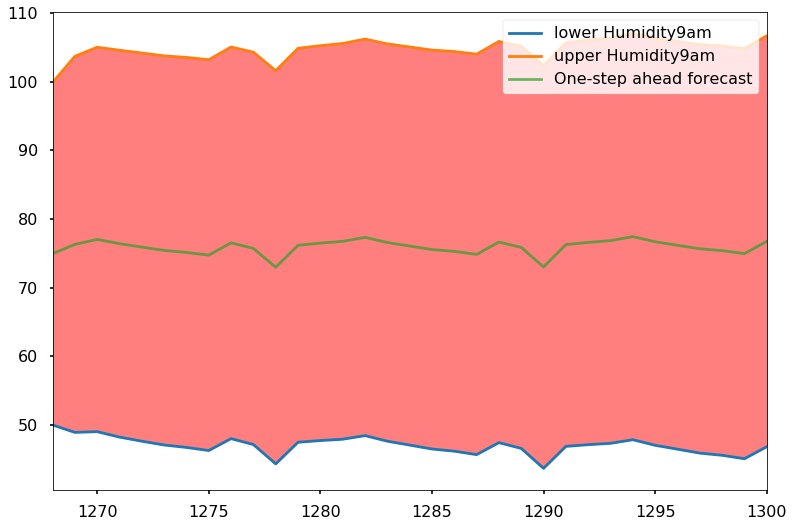

In [57]:
ax = pred_ci[:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

plt.legend()

plt.show()

In [58]:
df_attr.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
30481,0.566372,0.690763,0.057471,0.380952,0.606061,0.384615,0.513158,0.426966,0.325243,0.307506,0.641975,0.673554,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30484,0.216814,0.493976,0.000000,0.380952,0.666667,0.051282,0.263158,0.224719,0.366505,0.384988,0.329218,0.537190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30487,0.349558,0.345382,0.005747,0.317460,0.272727,0.615385,0.605263,0.528090,0.752427,0.731235,0.419753,0.392562,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30488,0.367257,0.393574,0.000000,0.380952,0.272727,0.666667,0.671053,0.539326,0.682039,0.653753,0.448560,0.454545,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30489,0.455752,0.453815,0.000000,0.380952,0.121212,0.435897,0.605263,0.595506,0.572816,0.542373,0.506173,0.491736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [60]:
df_attr.iloc[4:10]

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
30489,0.455752,0.453815,0.000000,0.380952,0.121212,0.435897,0.605263,0.595506,0.572816,0.542373,0.506173,0.491736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30490,0.477876,0.622490,0.000000,0.555556,0.151515,0.051282,0.460526,0.808989,0.456311,0.476998,0.604938,0.371901,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30491,0.402655,0.160643,0.879310,0.492063,0.606061,0.461538,0.894737,0.730337,0.565534,0.610169,0.304527,0.223140,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30493,0.349558,0.602410,0.005747,0.253968,0.333333,0.564103,0.644737,0.516854,0.490291,0.474576,0.456790,0.504132,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30494,0.433628,0.485944,0.000000,0.587302,0.333333,0.615385,0.684211,0.662921,0.441748,0.467312,0.555556,0.425620,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30495,0.504425,0.389558,0.051724,0.253968,0.454545,0.435897,0.539474,0.483146,0.575243,0.605327,0.477366,0.409091,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
from sklearn.feature_selection import SelectKBest, chi2
X = df_attr.loc[:,df_attr.columns!='RainTomorrow']
y = df_attr[['RainTomorrow']]
selector = SelectKBest(chi2, k=3)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index([u'Rainfall', u'RainToday', u'WindDir3pm_SSW'], dtype='object')


In [0]:
df_attr = df_attr[['Humidity3pm','Rainfall','RainToday','RainTomorrow']]
X = df_attr[['Humidity3pm']]
y = df_attr[['RainTomorrow']]

In [65]:
t0=time.time()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
clf_logreg = LogisticRegression(random_state=0)
clf_logreg.fit(X_train,y_train)
y_pred = clf_logreg.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

('Accuracy :', 0.812962962962963)
('Time taken :', 0.013093948364257812)


In [67]:
t0=time.time()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=4,random_state=0)
clf_rf.fit(X_train,y_train)
y_pred = clf_rf.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

('Accuracy :', 0.8203703703703704)
('Time taken :', 0.20740389823913574)


In [70]:
t0=time.time()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train,y_train)
y_pred = clf_dt.predict(X_test)
score = accuracy_score(y_test,y_pred)
print('Accuracy :',score)
print('Time taken :' , time.time()-t0)

('Accuracy :', 0.8111111111111111)
('Time taken :', 0.011260032653808594)


In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_attr[['Rainfall', 'Humidity3pm', 'RainToday']],df_attr['RainTomorrow'],test_size=0.25)

In [76]:
from sklearn.ensemble import AdaBoostClassifier
adaboost_classifier = AdaBoostClassifier(n_estimators = 100)
adaboost_classifier.fit(X_train, y_train)
adaboost_classifier_pred = adaboost_classifier.predict(X_test)
adaboost_classifier_score = accuracy_score(y_test, adaboost_classifier_pred)
print('The accuracy score obtained by adaboost classifier is:', adaboost_classifier_score)

('The accuracy score obtained by adaboost classifier is:', 0.825925925925926)


In [77]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_classifier = GradientBoostingClassifier()
gradient_boosting_classifier.fit(X_train, y_train)
gradient_boosting_classifier_pred = gradient_boosting_classifier.predict(X_test)
gradient_boosting_classifier_score = accuracy_score(y_test, gradient_boosting_classifier_pred)
print('The accuracy score obtained from gradient boosting classifier:', gradient_boosting_classifier_score)

('The accuracy score obtained from gradient boosting classifier:', 0.8296296296296296)
